# Project 1: Navigation

### Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

### Setup
Instantiate the Unity Environment for Project 1 (vector observation version of 'Banana'), retrieve the Unity brain name and extract the environment's state size (```s_sz```) and action size (```a_sz```).

In [2]:
# start Unity environment
env = UnityEnvironment(file_name="C:/Users/Andre/Desktop/Udacity DRL/deep-reinforcement-learning/p1_navigation/Banana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# get state size and action size
#env_info = env.reset(train_mode=False)[brain_name]
s_sz = brain.vector_observation_space_size# len(env_info.vector_observations[0])
a_sz = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### QNetwork class
Define the QNetwork object class, which will instantiate the Agent's neural networks for learning (local q network) and setting targets for learning of action values (target q network).

In [3]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        '''Creates a 2-hidden layer neural network with input and output size defined by
        state_size and output_size respectively. Hidden layer width is configured by fc1_units and fc2_units.
        
        Arguments
        =========
        . state_size (int): size of state space
        . action_size (int): size of action space
            '''
        super(QNetwork, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=state_size)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        '''Performs forward propagation on the QNetwork given a state input, to return action values.
        
        Arguments
        =========
        . state (torch float tensor): current state to obtain action values for.'''
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Agent class
Define an Agent class containing two instances of QNetwork (a local and target q network, to enable Fixed Q Targets), a memory buffer (to enable Experience Replay), and methods/attributes to save experience to memory, control learning to occur every X time-steps, select epsilon-greedy actions, update weights for the local q network and perform cloning/soft updating of the target q network.

In [4]:
class Agent():
    
    def __init__(self, state_size, action_size):
        '''Instantiates an Agent for Deep Q Networks.
        
        Arguments
        =========
        . state_size (int): size of state space
        . action_size (int): size of action space
        
        Attributes
        =========
        . state_size (int): size of state space.
        . action_size (int): size of action space.
        . qnetwork_local (instance of QNetwork class): local q network for learning action values.
        . qnetwork_target (instance of QNetwork class: target q network for directing learning.
        . optimizer: which optimizer to be used from torch.optim package.
        . memory (instance of ReplayBuffer): container and methods for storing, adding and organising
        experiences
        . t_step (int): time-step update counter.
        '''
        self.state_size = state_size
        self.action_size = action_size
        
        # 2x Q-networks to enable Fixed Q Targets
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        
        # Optimizer
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        
        # Replay memory to enable Experience Replay
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        
        # Timestep counter
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        '''Saves current experience in replay memory, calls 'learn' every 'update_every' time-steps.
        
        Arguments
        =========
        . state, action, reward, next_state, done: outputs of a single time-step of agent-environment
        interaction.
        '''
        # Save the current experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Check if current time step has reached update_every number of steps:
        self.t_step = (self.t_step + 1) % update_every
        
        # if so,
            # and if there are enough samples in memory, retrieve experiences and learn,
        if self.t_step == 0:
            if len(self.memory) > batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, gamma)
                
    def act(self, state, eps=0.):
        '''Selects an epsilon-greedy action.
        
        Arguments
        =========
        . state: Agent's current state.
        . eps (float): epsilon
        '''
        # process state into a tensor of the correct dimension for forward prop
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # set local network to evaluation mode (switch off dropout, batchnorm and gradient calc.)
        self.qnetwork_local.eval() 
        with torch.no_grad():
        # forward prop state thru local network to get current action value estimates
            action_values = self.qnetwork_local(state)
        # set network back to training mode
        self.qnetwork_local.train()
        
        # based on action values, return the epsilon-greedy action
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        '''Calculates approximate target Q values, current Q values and loss, then does 
        backpropagation, weight updating for local Q network and calls 'soft_update'.
        
        Arguments
        =========
        . experiences (5-tuple): output of agent.memory.sample: tuple of 5 torch float tensors where each
        contains respectively k states, actions, rewards, next_states and dones across all experiences
        in the batch of k experiences sampled.
        . gamma (float): discount factor for reward.
        '''
        # parse the elements of experiences tuple of tensors
        states, actions, rewards, next_states, dones = experiences
        
        # retrieve expected value of max value action for the next state, according to target network
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # and discount and add rewards to it to obtain targets, if episode didn't terminate 
            # at time step t+1. If it did, Q target becomes just the returned reward
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # forward prop in local network to retrieve current model for action values of states in batch
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # calculate mean squared error loss for batch of experiences,
            # run backprop and update weights based on it.
        loss = F.mse_loss(Q_expected, Q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # call soft_update to update target network weights.
        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)
    
    def soft_update(self, local_model, target_model, tau):
        '''Updates target q network as a tau-weighted average of local and target model parameters.
        
        Arguments
        =========
        . local_model (instance of QNetwork class): local q network.
        . target_model (instance of QNetwork class) target q network.
        . tau (float): weighting factor for local and target parameters. 
        '''
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### ReplayBuffer class
Define a class that the Agent will use to store experiences. Define methods of this class for organising stored experiences, append experiences to memory and retrieve experiences from memory for learning.

In [5]:
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size):
        '''Object that instantiates the Agent's memory for Experience Replay and associated methods.
        
        Arguments
        =========
        . action_size (int): size of action space.
        . buffer_size (int): replay memory capacity; max number of timesteps to store.
        . batch_size (int): number of experiences to recall for learning.
        
        Attributes
        ==========
        . action_size (int): size of action space.
        . storage (deque): storage container for experience tuples.
        . batch_size (int): number of experiences to recall for learning.
        . experience (function): names a tuple and parses its elements into state, action, reward,
        next_state and done.
        '''
        self.action_size = action_size
        self.memory_storage = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'action', 'reward', 'next_state', 'done'])
    
    def add(self, state, action, reward, next_state, done):
        '''Passes state, action, reward, next_state and done elements into a named tuple (Experience)
        and appends them to the memory_storage container.
        
        Arguments
        =========
        . state, action, reward, next_state, done: outputs of a single time-step of agent-environment
        interaction.
        '''
        e = self.experience(state, action, reward, next_state, done)
        self.memory_storage.append(e)
    
    def sample(self):
        '''Samples k (=batch_size) Experience tuples, parses and processes them to output a tuple
        of 5 torch float tensors each containing respectively k states, actions, rewards, next_states
        and dones across the k experiences sampled.        
        '''
        # retrieve a random 'batch_size' number of experience tuples to learn from
        experiences = random.sample(self.memory_storage, k = self.batch_size)
        
        # parse experience tuples into more convenient format, organised to bundle together
            # all experience elements of same type (ex: states) for every experience, 
                # rather than experience elements of different type but same experience.
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory_storage)

### Training function
Define a function for training the Agent in a Unity environment for a certain episode length and number of timesteps. Training function keeps track of scores per episode and window of 100 episodes, sets a decaying epsilon, uses an episode and timestep loop to control training flow by alternately calling the functions defined above, reports training progress by printing current score, saves the model's learnt parameters to a checkpoint at the end of training and returns the episode-by-episode scores.

In [9]:
def dqn(n_episodes = 2000, max_t=300, eps_start=1.0, eps_decay=0.995, eps_end=0.005,
        brain_name=brain_name, output='checkpoint'):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        score = 0
        
        for t in range(max_t):
        
            action = int(agent.act(state, eps=eps))
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break
    
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_end*eps)

        print('\rEpisode {}\tAverage Score {:.2f}'.format(i_episode, np.mean(scores_window)), end='')
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    torch.save(agent.qnetwork_local.state_dict(), '{}.pth'.format(output))

    return scores

### Hyperparameters and GPU
Pick a device to train on and set hyperparameters for training.

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training on {}.'.format(device))

buffer_size = 300000#int(1e6)
batch_size = 32
gamma = 0.99
tau = 1e-3
lr = 5e-4
update_every = 4

Training on cuda:0.


## Train & Plot results
Instantiate agent & run training function for a chosen number of episodes.

In [14]:
agent = Agent(state_size=s_sz, action_size=a_sz)
scores = dqn(n_episodes = 2000, output='banana_submission')

Episode 100	Average Score: 4.32
Episode 200	Average Score: 7.78
Episode 300	Average Score: 12.94
Episode 400	Average Score: 14.96
Episode 500	Average Score: 15.04
Episode 600	Average Score: 14.47
Episode 700	Average Score: 14.78
Episode 800	Average Score: 15.22
Episode 900	Average Score: 15.50
Episode 1000	Average Score: 15.77
Episode 1100	Average Score: 14.99
Episode 1200	Average Score: 15.35
Episode 1300	Average Score: 16.12
Episode 1400	Average Score: 14.30
Episode 1500	Average Score: 14.57
Episode 1600	Average Score: 14.72
Episode 1700	Average Score: 15.70
Episode 1800	Average Score: 15.91
Episode 1900	Average Score: 16.18
Episode 2000	Average Score: 14.75


In [35]:
roll_avg = [np.average(scores[i-99:i]) for i in range(99,len(scores))]

Text(2200, 19, ' - Episode by episode score')

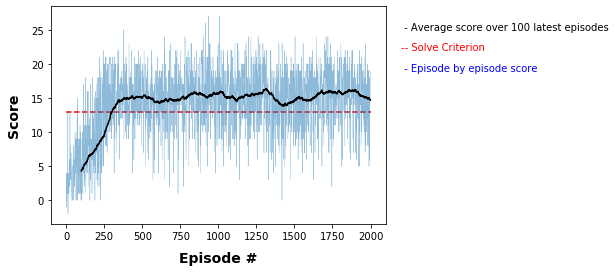

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, lw = 0.4, alpha =0.5);
plt.ylabel('Score', fontweight='bold', fontsize=14, labelpad=10);
plt.xlabel('Episode #', fontweight='bold', fontsize=14, labelpad=10);
plt.hlines(y=13.0, xmin=0, xmax=2000, linestyle={'dashed'}, color = 'red')
plt.plot(range(99,len(scores)),roll_avg, color='k');
plt.text(2200, 25, ' - Average score over 100 latest episodes', color='k');
plt.text(2200, 22, '-- Solve Criterion', color='red');
plt.text(2200, 19, ' - Episode by episode score', color='b');
#plt.show()